In [116]:
!pip install git+https://github.com/deepvision-class/starter-code

  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-_3trzzsd
  Running command git clone -q https://github.com/deepvision-class/starter-code /tmp/pip-req-build-_3trzzsd
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-cp36-none-any.whl size=10324 sha256=812c051251f73c8dc3f2b512ae72d4056a8591918791ff2ec3996b7822c1bc28
  Stored in directory: /tmp/pip-ephem-wheel-cache-7kljw142/wheels/63/d1/27/a208931527abb98d326d00209f46c80c9d745851d6a1defd10
Successfully built Colab-Utils


In [117]:

from __future__ import print_function
from __future__ import division
import torch
import coutils
import random
import time
import math
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [118]:
if torch.cuda.is_available:
    print('Good')
else:
    print('please set GPU')

Good


torch.Size([50000, 3, 32, 32])


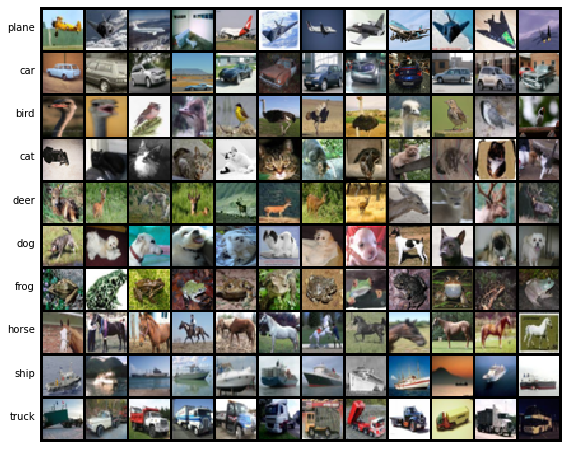

torch.Size([49000, 3073])
torch.Size([49000])
torch.Size([1000, 3073])
torch.Size([1000])
torch.Size([10000, 3073])
torch.Size([10000])


In [119]:
def get_CIFAR10_data(validation_ratio = 0.02):
    X_train, y_train, X_test, y_test = coutils.data.cifar10()
    print(X_train.shape)
    X_train = X_train.cuda()
    y_train = y_train.cuda()
    X_test = X_test.cuda()
    y_test = y_test.cuda()
    class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    img = coutils.utils.visualize_dataset(X_train, y_train, 12, class_names)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    # 1. Normalize the data: subtract the mean RGB (zero mean)
    mean_image = X_train.mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
    X_train -= mean_image
    X_test -= mean_image

    # 2. Reshape the image data into rows
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    # 3. Add bias dimension and transform into columns
    ones_train = torch.ones(X_train.shape[0], 1, device=X_train.device)
    X_train = torch.cat([X_train, ones_train], dim=1)
    ones_test = torch.ones(X_test.shape[0], 1, device=X_test.device)
    X_test = torch.cat([X_test, ones_test], dim=1)

    # 4. Carve out part of the training set to use for validation.
    num_training = int(X_train.shape[0] * (1.0 - validation_ratio))
    num_validation = X_train.shape[0] - num_training

    # Return the dataset as a dictionary
    data_dict = {}
    data_dict['X_val'] = X_train[num_training:num_training + num_validation]
    data_dict['y_val'] = y_train[num_training:num_training + num_validation]
    data_dict['X_train'] = X_train[0:num_training]
    data_dict['y_train'] = y_train[0:num_training]

    data_dict['X_test'] = X_test
    data_dict['y_test'] = y_test
    return data_dict

data_dict = get_CIFAR10_data()
print(data_dict['X_train'].shape)
print(data_dict['y_train'].shape)
print(data_dict['X_val'].shape)
print(data_dict['y_val'].shape)
print(data_dict['X_test'].shape)
print(data_dict['y_test'].shape)

In [120]:
a= torch.tensor([[1,2],[2,3],[4,5]])
a= a.float()
print(a.mean(dim=0, keepdim=True))

tensor([[2.3333, 3.3333]])


In [121]:
a = torch.tensor([[[1.0,2],[2,3],[4,5]], [[3.0,5],[1,2],[9,8]]])
print(a.mean(dim = 0, keepdim=True))
print(a.mean(dim = 0, keepdim=True).mean(dim=2,keepdim=True))

tensor([[[2.0000, 3.5000],
         [1.5000, 2.5000],
         [6.5000, 6.5000]]])
tensor([[[2.7500],
         [2.0000],
         [6.5000]]])


In [122]:
def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-7):
    coutils.utils.fix_random_seed()

    for i in range(num_checks):
        ix = tuple([random.randrange(m) for m in x.shape])
        oldval = x[ix].item()
        x[ix] = oldval + h
        fxph = f(x).item()
        x[ix] = oldval -  h
        fxmh = f(x).item()
        x[ix] = oldval

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error_top = abs(grad_numerical - grad_analytic)
        rel_error_bot = (abs(grad_numerical) + abs(grad_analytic) + 1e-12)
        rel_error = rel_error_top / rel_error_bot
        msg = 'numerical: %f analytic: %f, relative error: %e'
        print(msg % (grad_numerical, grad_analytic, rel_error))

In [123]:
import random
import torch
l = torch.tensor([9,2,10])
b = [random.randrange(m) for m in l.shape]
print(b)
a = tuple([random.randrange(m) for m in l.shape])
print(a)
print(l[a].item())

[0]
(1,)
2


# dW는 loss function을 W에 대해 미분을 하였다는 의미!!

In [124]:
def svm_loss_naive(W, X, y, reg):
  """
  Structured SVM loss function, naive implementation (with loops).

  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples. When you implment the regularization over W, please DO NOT
  multiply the regularization term by 1/2 (no coefficient). 

  Inputs:
  - W: A PyTorch tensor of shape (D, C) containing weights.
  - X: A PyTorch tensor of shape (N, D) containing a minibatch of data.
  - y: A PyTorch tensor of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as torch scalar
  - gradient of loss with respect to weights W; a tensor of same shape as W
  """
  dW = torch.zeros_like(W) # initialize the gradient as zero

  # compute the loss and the gradient
  num_classes = W.shape[1]
  num_train = X.shape[0]
  loss = 0.0
  for i in range(num_train):
    scores = W.t().mv(X[i])
    correct_class_score = scores[y[i]]
    for j in range(num_classes):
      if j == y[i]:
        continue
      margin = scores[j] - correct_class_score + 1 # note delta = 1
      if margin > 0:
        loss += margin
        #######################################################################
        # TODO:                                                               #
        # Compute the gradient of the loss function and store it dW. (part 1) #
        # Rather that first computing the loss and then computing the         #
        # derivative, it is simple to compute the derivative at the same time #
        # that the loss is being computed.                                    #
        #######################################################################
        # Replace "pass" statement with your code
        dW[:,j] += X[i]
        dW[:,y[i]] -= X[i]
        #######################################################################
        #                       END OF YOUR CODE                              #
        #######################################################################
        

  # Right now the loss is a sum over all training examples, but we want it
  # to be an average instead so we divide by num_train.
  loss /= num_train

  # Add regularization to the loss.
  loss += reg * torch.sum(W * W)

  #############################################################################
  # TODO:                                                                     #
  # Compute the gradient of the loss function and store it in dW. (part 2)    #
  #############################################################################
  # Replace "pass" statement with your code
  dW = dW/num_train + reg * 2 * W
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################

  return loss, dW

In [125]:
# generate a random SVM weight tensor of small numbers
coutils.utils.fix_random_seed()
W = torch.randn(3073, 10, device=data_dict['X_val'].device) * 0.0001 

loss, grad = svm_loss_naive(W, data_dict['X_val'], data_dict['y_val'], 0.000005)
print('loss: %f' % (loss, ))

loss: 9.000433


In [126]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Use a random W and a minibatch of data from the val set for gradient checking
# For numeric gradient checking it is a good idea to use 64-bit floating point
# numbers for increased numeric precision; however when actually training models
# we usually use 32-bit floating point numbers for increased speed.
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()
batch_size = 64
X_batch = data_dict['X_val'][:64].double()
y_batch = data_dict['y_val'][:64]

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W.double(), X_batch, y_batch, reg=0.0) 

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should
# match almost exactly along all dimensions.
f = lambda w: svm_loss_naive(w, X_batch, y_batch, reg=0.0)[0]
grad_numerical = grad_check_sparse(f, W.double(), grad)

numerical: -0.034577 analytic: -0.034577, relative error: 2.372452e-07
numerical: 0.126951 analytic: 0.126951, relative error: 5.721190e-08
numerical: -0.068597 analytic: -0.068597, relative error: 2.249695e-07
numerical: 0.025717 analytic: 0.025717, relative error: 4.774223e-07
numerical: 0.048266 analytic: 0.048266, relative error: 2.668362e-07
numerical: 0.052260 analytic: 0.052260, relative error: 2.475153e-07
numerical: 0.096133 analytic: 0.096133, relative error: 4.690208e-09
numerical: 0.032702 analytic: 0.032702, relative error: 3.644517e-07
numerical: -0.117158 analytic: -0.117158, relative error: 4.006759e-08
numerical: -0.154093 analytic: -0.154093, relative error: 7.809949e-08


In [127]:
def svm_loss_vectorized(W, X, y, reg):
  """
  Structured SVM loss function, vectorized implementation. When you implment 
  the regularization over W, please DO NOT multiply the regularization term by 
  1/2 (no coefficient). 

  Inputs and outputs are the same as svm_loss_naive.
  """
  loss = 0.0
  dW = torch.zeros_like(W) # initialize the gradient as zero

  #############################################################################
  # TODO:                                                                     #
  # Implement a vectorized version of the structured SVM loss, storing the    #
  # result in loss.                                                           #
  #############################################################################
  # Replace "pass" statement with your code
  z = torch.mm(X, W)
  num_train = X.shape[0]
  num_classes = W.shape[1]
  correct_label_idx = (torch.arange(num_train), y)
  zero = torch.zeros_like(z)
  print(z[correct_label_idx].shape)
  margin = torch.max(zero, z - z[correct_label_idx].view(-1,1) + 1)
  margin[correct_label_idx] = 0
  loss = torch.sum(margin) / num_train + reg * torch.sum(W * W)
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################


  #############################################################################
  # TODO:                                                                     #
  # Implement a vectorized version of the gradient for the structured SVM     #
  # loss, storing the result in dW.                                           #
  #                                                                           #
  # Hint: Instead of computing the gradient from scratch, it may be easier    #
  # to reuse some of the intermediate values that you used to compute the     #
  # loss.                                                                     #
  #############################################################################
  # Replace "pass" statement with your code
  mask = torch.zeros_like(margin)
  mask[margin > 0] = 1
  count = torch.sum(mask, dim=1)
  mask[correct_label_idx] = -count
  dW = torch.mm(X.t(), mask) / num_train + 2 * reg * W
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################

  return loss, dW

In [128]:
y = torch.tensor([1,0,2])
a= torch.tensor([[0,1,2],[3,4,5],[6,7,8]])
b = (range(3), y)
print(b)
print(a[b])
c = torch.tensor([1,2,3])
print(a-c.view(3,-1))
print(a + 1)

(range(0, 3), tensor([1, 0, 2]))
tensor([1, 3, 8])
tensor([[-1,  0,  1],
        [ 1,  2,  3],
        [ 3,  4,  5]])
tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])


In [129]:
# generate a random SVM weight tensor of small numbers
coutils.utils.fix_random_seed()
W = torch.randn(3073, 10, device=data_dict['X_val'].device) * 0.0001 

loss, grad = svm_loss_vectorized(W, data_dict['X_val'], data_dict['y_val'], 0.000005)
print('loss: %f' % (loss, ))

torch.Size([1000])
loss: 9.000404


In [130]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.

# Use random weights and a minibatch of val data for gradient checking
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()
X_batch = data_dict['X_val'][:128].double()
y_batch = data_dict['y_val'][:128]
reg = 0.000005

# Run and time the naive version
torch.cuda.synchronize()
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('Naive loss: %e computed in %.2fms' % (loss_naive, ms_naive))

# Run and time the vectorized version
torch.cuda.synchronize()
tic = time.time()
loss_vec, _ = svm_loss_vectorized(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('Vectorized loss: %e computed in %.2fms' % (loss_vec, ms_vec))

# The losses should match but your vectorized implementation should be much faster.
print('Difference: %.2e' % (loss_naive - loss_vec))
print('Speedup: %.2fX' % (ms_naive / ms_vec))

Naive loss: 9.000144e+00 computed in 307.79ms
torch.Size([128])
Vectorized loss: 9.000144e+00 computed in 3.61ms
Difference: -1.07e-14
Speedup: 85.18X


In [131]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Use a random W and a minibatch of data from the val set for gradient checking
# For numeric gradient checking it is a good idea to use 64-bit floating point
# numbers for increased numeric precision; however when actually training models
# we usually use 32-bit floating point numbers for increased speed.
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()
batch_size = 64
X_batch = data_dict['X_val'][:64].double()
y_batch = data_dict['y_val'][:64]

# Compute the loss and its gradient at W.
loss, grad = svm_loss_vectorized(W.double(), X_batch, y_batch, reg=0.0) 

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should
# match almost exactly along all dimensions.
f = lambda w: svm_loss_vectorized(w, X_batch, y_batch, reg=0.0)[0]
grad_numerical = grad_check_sparse(f, W.double(), grad)

torch.Size([64])
torch.Size([64])
torch.Size([64])
numerical: -0.034577 analytic: -0.034577, relative error: 1.962755e-08
torch.Size([64])
torch.Size([64])
numerical: 0.126951 analytic: 0.126951, relative error: 1.275037e-08
torch.Size([64])
torch.Size([64])
numerical: -0.068597 analytic: -0.068597, relative error: 3.075239e-08
torch.Size([64])
torch.Size([64])
numerical: 0.025717 analytic: 0.025717, relative error: 4.062602e-08
torch.Size([64])
torch.Size([64])
numerical: 0.048266 analytic: 0.048266, relative error: 9.192114e-09
torch.Size([64])
torch.Size([64])
numerical: 0.052260 analytic: 0.052260, relative error: 7.414866e-09
torch.Size([64])
torch.Size([64])
numerical: 0.096133 analytic: 0.096133, relative error: 4.150526e-08
torch.Size([64])
torch.Size([64])
numerical: 0.032702 analytic: 0.032702, relative error: 4.294649e-08
torch.Size([64])
torch.Size([64])
numerical: -0.117158 analytic: -0.117158, relative error: 2.162472e-09
torch.Size([64])
torch.Size([64])
numerical: -0.15

In [132]:
# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.

# Use random weights and a minibatch of val data for gradient checking
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()
X_batch = data_dict['X_val'][:128].double()
y_batch = data_dict['y_val'][:128]
reg = 0.000005

# Run and time the naive version
torch.cuda.synchronize()
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_batch, y_batch, 0.000005)
torch.cuda.synchronize()
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('Naive loss and gradient: computed in %.2fms' % ms_naive)

# Run and time the vectorized version
torch.cuda.synchronize()
tic = time.time()
_, grad_vec = svm_loss_vectorized(W, X_batch, y_batch, 0.000005)
torch.cuda.synchronize()
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('Vectorized loss and gradient: computed in %.2fms' % ms_vec)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a tensor, so
# we use the Frobenius norm to compare them.
grad_difference = torch.norm(grad_naive - grad_vec, p='fro')
print('Gradient difference: %.2e' % grad_difference)
print('Speedup: %.2fX' % (ms_naive / ms_vec))

Naive loss and gradient: computed in 295.56ms
torch.Size([128])
Vectorized loss and gradient: computed in 3.57ms
Gradient difference: 0.00e+00
Speedup: 82.76X


In [133]:
def train_linear_classifier(loss_func, W, X, y, learning_rate=1e-3, 
                            reg=1e-5, num_iters=100, batch_size=200, verbose=False):
  """
  Train this linear classifier using stochastic gradient descent.

  Inputs:
  - loss_func: loss function to use when training. It should take W, X, y
    and reg as input, and output a tuple of (loss, dW)
  - W: A PyTorch tensor of shape (D, C) giving the initial weights of the
    classifier. If W is None then it will be initialized here.
  - X: A PyTorch tensor of shape (N, D) containing training data; there are N
    training samples each of dimension D.
  - y: A PyTorch tensor of shape (N,) containing training labels; y[i] = c
    means that X[i] has label 0 <= c < C for C classes.
  - learning_rate: (float) learning rate for optimization.
  - reg: (float) regularization strength.
  - num_iters: (integer) number of steps to take when optimizing
  - batch_size: (integer) number of training examples to use at each step.
  - verbose: (boolean) If true, print progress during optimization.

  Returns: A tuple of:
  - W: The final value of the weight matrix and the end of optimization
  - loss_history: A list of Python scalars giving the values of the loss at each
    training iteration.
  """
  # assume y takes values 0...K-1 where K is number of classes
  num_classes = torch.max(y) + 1
  num_train, dim = X.shape
  if W is None:
    # lazily initialize W
    W = 0.000001 * torch.randn(dim, num_classes, device=X.device, dtype=X.dtype)

  # Run stochastic gradient descent to optimize W
  loss_history = []
  for it in range(num_iters):
    X_batch = None
    y_batch = None
    #########################################################################
    # TODO:                                                                 #
    # Sample batch_size elements from the training data and their           #
    # corresponding labels to use in this round of gradient descent.        #
    # Store the data in X_batch and their corresponding labels in           #
    # y_batch; after sampling, X_batch should have shape (batch_size, dim)  #
    # and y_batch should have shape (batch_size,)                           #
    #                                                                       #
    # Hint: Use torch.randint to generate indices.                          #
    #########################################################################
    # Replace "pass" statement with your code
    indices = torch.randint(num_train, (batch_size,))
    X_batch = X[indices]
    y_batch = y[indices]
    #########################################################################
    #                       END OF YOUR CODE                                #
    #########################################################################

    # evaluate loss and gradient
    loss, grad = loss_func(W, X_batch, y_batch, reg)
    loss_history.append(loss.item())

    # perform parameter update
    #########################################################################
    # TODO:                                                                 #
    # Update the weights using the gradient and the learning rate.          #
    #########################################################################
    # Replace "pass" statement with your code
    W -= learning_rate * grad
    #########################################################################
    #                       END OF YOUR CODE                                #
    #########################################################################

    if verbose and it % 100 == 0:
      print('iteration %d / %d: loss %f' % (it, num_iters, loss))

  return W, loss_history

In [134]:
# fix random seed before we perform this operation
coutils.utils.fix_random_seed()

torch.cuda.synchronize()
tic = time.time()

W, loss_hist = train_linear_classifier(svm_loss_vectorized, None, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=3e-11, reg=2.5e4,
                                       num_iters=1500, verbose=True)

torch.cuda.synchronize()
toc = time.time()
print('That took %fs' % (toc - tic))

torch.Size([200])
iteration 0 / 1500: loss 9.000759
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([

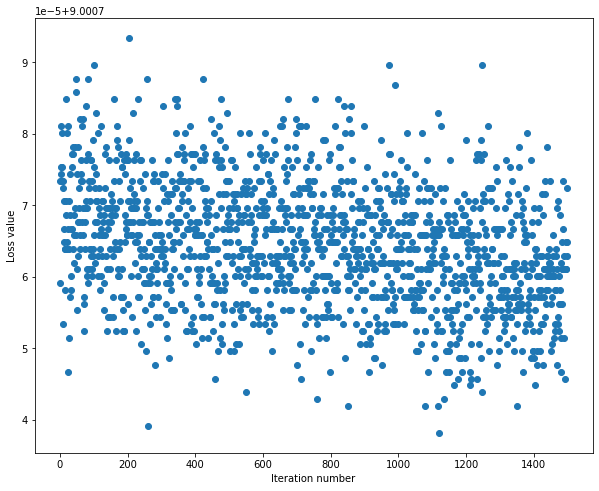

In [135]:
plt.plot(loss_hist, 'o')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [136]:
def predict_linear_classifier(W, X):
  """
  Use the trained weights of this linear classifier to predict labels for
  data points.

  Inputs:
  - W: A PyTorch tensor of shape (D, C), containing weights of a model
  - X: A PyTorch tensor of shape (N, D) containing training data; there are N
    training samples each of dimension D.

  Returns:
  - y_pred: PyTorch int64 tensor of shape (N,) giving predicted labels for each
    elemment of X. Each element of y_pred should be between 0 and C - 1.
  """
  y_pred = torch.zeros(X.shape[0])
  ###########################################################################
  # TODO:                                                                   #
  # Implement this method. Store the predicted labels in y_pred.            #
  ###########################################################################
  # Replace "pass" statement with your code
  n_y_pred = torch.mm(X, W)
  y_pred = torch.argmax(n_y_pred, dim=1)
  ###########################################################################
  #                           END OF YOUR CODE                              #
  ###########################################################################
  return y_pred

In [137]:
# evaluate the performance on both the training and validation set
y_train_pred = predict_linear_classifier(W, data_dict['X_train'])
train_acc = 100.0 * (data_dict['y_train'] == y_train_pred).float().mean().item()
print('Training accuracy: %.2f%%' % train_acc)
y_val_pred = predict_linear_classifier(W, data_dict['X_val'])
val_acc = 100.0 * (data_dict['y_val'] == y_val_pred).float().mean().item()
print('Validation accuracy: %.2f%%' % val_acc)

Training accuracy: 10.24%
Validation accuracy: 10.20%


In [138]:
# Note: We will re-use `LinearClassifier' in Softmax section
class LinearClassifier(object):
  
  def __init__(self):
    self.W = None
    
  def train(self, X_train, y_train, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    train_args = (self.loss, self.W, X_train, y_train, learning_rate, reg,
                  num_iters, batch_size, verbose)
    self.W, loss_history = train_linear_classifier(*train_args)
    return loss_history

  def predict(self, X):
    return predict_linear_classifier(self.W, X) 
  
  def loss(self, W, X_batch, y_batch, reg):
    """
    Compute the loss function and its derivative. 
    Subclasses will override this.

    Inputs:
    - W: A PyTorch tensor of shape (D, C) containing (trained) weight of a model.
    - X_batch: A PyTorch tensor of shape (N, D) containing a minibatch of N
      data points; each point has dimension D.
    - y_batch: A PyTorch tensor of shape (N,) containing labels for the minibatch.
    - reg: (float) regularization strength.

    Returns: A tuple containing:
    - loss as a single float
    - gradient with respect to self.W; an tensor of the same shape as W
    """
    pass
  def _loss(self, X_batch, y_batch, reg):
    self.loss(self.W, X_batch, y_batch, reg)

  
class LinearSVM(LinearClassifier):
  """ A subclass that uses the Multiclass SVM loss function """

  def loss(self, W, X_batch, y_batch, reg):
    return svm_loss_vectorized(W, X_batch, y_batch, reg)

In [139]:
# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.
learning_rates = [] # learning rate candidates, e.g. [1e-3, 1e-2, ...]
regularization_strengths = [] # regularization strengths candidates e.g. [1e0, 1e1, ...]

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# Replace "pass" statement with your codㅌ
X_train = data_dict['X_train']
y_train = data_dict['y_train']
X_val = data_dict['X_val']
y_val = data_dict['y_val']
learning_rate = [3e-3, 5e-3, 7e-3, 9e-3, 1e-2, 2e-2, 3e-2]
regularization_strengths = [1e-1, 3e-1, 5e-1, 7e-1, 9e-1, 1e0, 2e0, 3e0]
for l in learning_rate:
    for r in regularization_strengths:
        model = LinearSVM()
        train_loss = model.train(X_train, y_train, learning_rate=l, reg=r, num_iters=100, verbose=False)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        train_acc = torch.mean((y_train_pred == y_train).float())
        val_acc = torch.mean((y_val_pred == y_val).float())

        results[l, r] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = model
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
  train_accuracy, val_accuracy = results[(lr, reg)]
  print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
         lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size

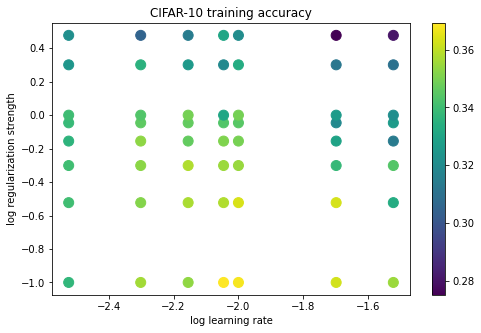

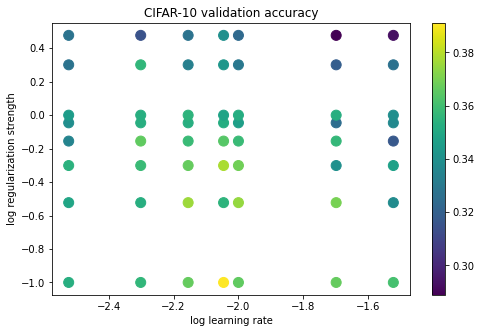

In [140]:
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results] # x is key of dict "results"
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

In [141]:
y_test_pred = best_svm.predict(data_dict['X_test'])
test_accuracy = torch.mean((data_dict['y_test'] == y_test_pred).float())
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.369600


torch.Size([3072, 10])
torch.Size([32, 32, 3, 10])


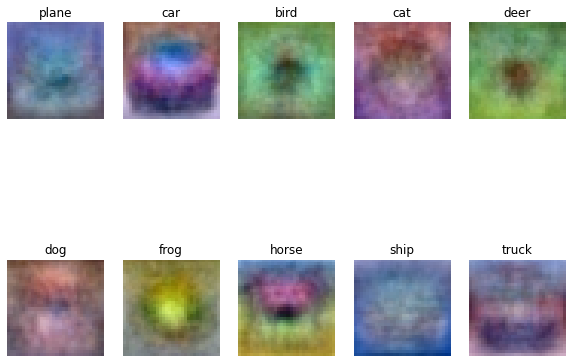

In [142]:
w = best_svm.W[:-1,:] # strip out the bias
print(w.shape)
w = w.reshape(3, 32, 32, 10)
w = w.transpose(0, 2).transpose(1, 0)
print(w.shape)
w_min, w_max = torch.min(w), torch.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1) # 행 2개 열 5개 각각의 칸 1 ~ 10

  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.type(torch.uint8).cpu())
  plt.axis('off')
  plt.title(classes[i])

In [143]:
a = torch.tensor([[1,2],[2,3],[3,4]])
print(a[:-1,:])
print(a.transpose(1,0))
print(a.transpose(0,1))

tensor([[1, 2],
        [2, 3]])
tensor([[1, 2, 3],
        [2, 3, 4]])
tensor([[1, 2, 3],
        [2, 3, 4]])


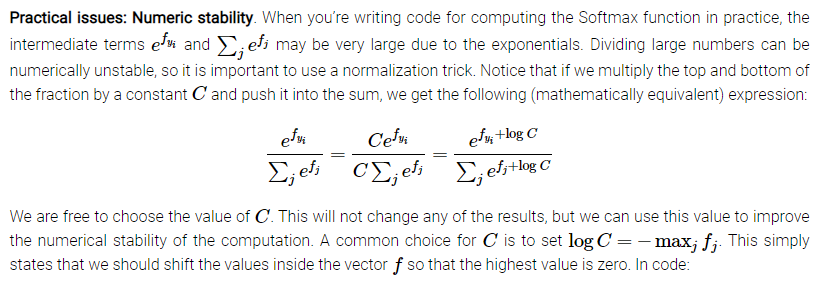

In [144]:
def softmax_loss_naive(W, X, y, reg):
  """
  Softmax loss function, naive implementation (with loops).  When you implment 
  the regularization over W, please DO NOT multiply the regularization term by 
  1/2 (no coefficient). 

  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.

  Inputs:
  - W: A PyTorch tensor of shape (D, C) containing weights.
  - X: A PyTorch tensor of shape (N, D) containing a minibatch of data.
  - y: A PyTorch tensor of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an tensor of same shape as W
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = torch.zeros_like(W)
  
  #############################################################################
  # TODO: Compute the softmax loss and its gradient using explicit loops.     #
  # Store the loss in loss and the gradient in dW. If you are not careful     #
  # here, it is easy to run into numeric instability (Check Numeric Stability #
  # in http://cs231n.github.io/linear-classify/). Plus, don't forget the      #
  # regularization!                                                           #
  #############################################################################
  # Replace "pass" statement with your code
  C = W.shape[1]
  N = X.shape[0]
  for i in range(N):
      scores = W.t().mv(X[i])
      scores -= torch.max(scores)
      prob = torch.exp(scores[y[i]])
      expsum = torch.sum(torch.exp(scores))
      loss += -torch.log(prob / expsum)
      
      for j in range(C):
          if j == y[i]:
              continue
          
          dW[:, j] += torch.exp(scores[j]) / expsum * X[i]
      dW[:, y[i]] += (prob / expsum - 1.0) * X[i]

  loss = loss / N + reg * torch.sum(W * W)
  dW = dW / N + 2 * reg * W
  #############################################################################
  #                          END OF YOUR CODE                                 #
  #############################################################################

  return loss, dW

In [145]:
# Generate a random softmax weight tensor and use it to compute the loss.
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()

X_batch = data_dict['X_val'][:128].double()
y_batch = data_dict['y_val'][:128]

# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_batch, y_batch, reg=0.0)

# As a rough sanity check, our loss should be something close to log(10.0).
print('loss: %f' % loss)
print('sanity check: %f' % (math.log(10.0)))

loss: 2.302600
sanity check: 2.302585


In [146]:
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()
X_batch = data_dict['X_val'][:128].double()
y_batch = data_dict['y_val'][:128]

loss, grad = softmax_loss_naive(W, X_batch, y_batch, reg=0.0)

f = lambda w: softmax_loss_naive(w, X_batch, y_batch, reg=0.0)[0]
grad_check_sparse(f, W, grad, 10)

numerical: 0.008387 analytic: 0.008387, relative error: 1.366549e-07
numerical: 0.009227 analytic: 0.009227, relative error: 1.339656e-07
numerical: -0.002471 analytic: -0.002471, relative error: 1.718331e-07
numerical: -0.003144 analytic: -0.003144, relative error: 2.403080e-06
numerical: 0.006011 analytic: 0.006011, relative error: 6.813253e-08
numerical: 0.005936 analytic: 0.005936, relative error: 2.473992e-07
numerical: 0.015703 analytic: 0.015703, relative error: 2.149831e-08
numerical: 0.006452 analytic: 0.006452, relative error: 2.068055e-09
numerical: -0.015533 analytic: -0.015533, relative error: 2.569959e-07
numerical: -0.010170 analytic: -0.010170, relative error: 4.657956e-07


In [147]:
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()
reg = 10.0

X_batch = data_dict['X_val'][:128].double()
y_batch = data_dict['y_val'][:128]

loss, grad = softmax_loss_naive(W, X_batch, y_batch, reg)

f = lambda w: softmax_loss_naive(w, X_batch, y_batch, reg)[0]
grad_check_sparse(f, W, grad, 10)

numerical: 0.007517 analytic: 0.007517, relative error: 2.286123e-07
numerical: 0.008167 analytic: 0.008167, relative error: 1.238116e-07
numerical: -0.002551 analytic: -0.002551, relative error: 3.147037e-08
numerical: -0.000841 analytic: -0.000841, relative error: 8.976250e-06
numerical: 0.002228 analytic: 0.002228, relative error: 4.070641e-07
numerical: 0.005460 analytic: 0.005460, relative error: 1.891176e-07
numerical: 0.015762 analytic: 0.015762, relative error: 7.076879e-08
numerical: 0.007097 analytic: 0.007097, relative error: 1.474077e-07
numerical: -0.015532 analytic: -0.015532, relative error: 2.149161e-07
numerical: -0.011201 analytic: -0.011201, relative error: 3.391712e-07


In [148]:
def softmax_loss_vectorized(W, X, y, reg):
  """
  Softmax loss function, vectorized version.  When you implment the 
  regularization over W, please DO NOT multiply the regularization term by 1/2 
  (no coefficient). 

  Inputs and outputs are the same as softmax_loss_naive.
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = torch.zeros_like(W)

  #############################################################################
  # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
  # Store the loss in loss and the gradient in dW. If you are not careful     #
  # here, it is easy to run into numeric instability (Check Numeric Stability #
  # in http://cs231n.github.io/linear-classify/). Don't forget the            #
  # regularization!                                                           #
  #############################################################################
  # Replace "pass" statement with your code
  N = X.shape[0]
  z = torch.mm(X, W)
  z -= torch.max(z, dim=1)[0].view(-1,1)
  expsum = torch.sum(torch.exp(z), dim=1)
  correct = torch.exp(z)[torch.arange(N), y]
  prob = correct / expsum
  loss = - torch.sum(torch.log(prob)) / N + reg * torch.sum(W * W)

  factor = torch.exp(z) / expsum.view(-1, 1)
  factor[torch.arange(N), y] -= 1
  dW = torch.mm(X.t(), factor) / N + 2 * reg * W
  #############################################################################
  #                          END OF YOUR CODE                                 #
  #############################################################################

  return loss, dW

In [149]:
a = torch.tensor([[1,2,3],[2,3,4],[4,5,6]])
b = torch.tensor([[2,3,4],[1,4,5],[2,3,5]])
print(a/b)
print(torch.max(a,dim=1))
print(a - torch.max(a,dim=1)[0].view(-1,1))

tensor([[0.5000, 0.6667, 0.7500],
        [2.0000, 0.7500, 0.8000],
        [2.0000, 1.6667, 1.2000]])
torch.return_types.max(
values=tensor([3, 4, 6]),
indices=tensor([2, 2, 2]))
tensor([[-2, -1,  0],
        [-2, -1,  0],
        [-2, -1,  0]])


In [150]:
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device)
reg = 0.05

X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]

# Run and time the naive version
torch.cuda.synchronize()
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('naive loss: %e computed in %fs' % (loss_naive, ms_naive))

# Run and time the vectorized version
torch.cuda.synchronize()
tic = time.time()
loss_vec, grad_vec = softmax_loss_vectorized(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('vectorized loss: %e computed in %fs' % (loss_vec, ms_vec))

# we use the Frobenius norm to compare the two versions of the gradient.
loss_diff = (loss_naive - loss_vec).abs().item()
grad_diff = torch.norm(grad_naive - grad_vec, p='fro')
print('Loss difference: %.2e' % loss_diff)
print('Gradient difference: %.2e' % grad_diff)
print('Speedup: %.2fX' % (ms_naive / ms_vec))

naive loss: 2.302615e+00 computed in 190.304756s
vectorized loss: 2.302616e+00 computed in 1.282215s
Loss difference: 4.77e-07
Gradient difference: 3.20e-07
Speedup: 148.42X


In [151]:
device = data_dict['X_train'].device
dtype = torch.float32
D = data_dict['X_train'].shape[1]
C = 10

W_ones = torch.ones(D, C, device=device, dtype=dtype)
W, loss_hist = train_linear_classifier(softmax_loss_naive, W_ones, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=1e-8, reg=2.5e4,
                                       num_iters=1, verbose=True)


W_ones = torch.ones(D, C, device=device, dtype=dtype)
W, loss_hist = train_linear_classifier(softmax_loss_vectorized, W_ones, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=1e-8, reg=2.5e4,
                                       num_iters=1, verbose=True)

iteration 0 / 1: loss 768249984.000000
iteration 0 / 1: loss 768249984.000000


In [152]:
# fix random seed before we perform this operation
coutils.utils.fix_random_seed(10)

torch.cuda.synchronize()
tic = time.time()

W, loss_hist = train_linear_classifier(softmax_loss_vectorized, None, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=1e-10, reg=2.5e4,
                                       num_iters=1500, verbose=True)

torch.cuda.synchronize()
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 2.303346
iteration 100 / 1500: loss 2.303344
iteration 200 / 1500: loss 2.303344
iteration 300 / 1500: loss 2.303342
iteration 400 / 1500: loss 2.303342
iteration 500 / 1500: loss 2.303342
iteration 600 / 1500: loss 2.303342
iteration 700 / 1500: loss 2.303341
iteration 800 / 1500: loss 2.303338
iteration 900 / 1500: loss 2.303339
iteration 1000 / 1500: loss 2.303339
iteration 1100 / 1500: loss 2.303336
iteration 1200 / 1500: loss 2.303335
iteration 1300 / 1500: loss 2.303337
iteration 1400 / 1500: loss 2.303334
That took 1.085659s


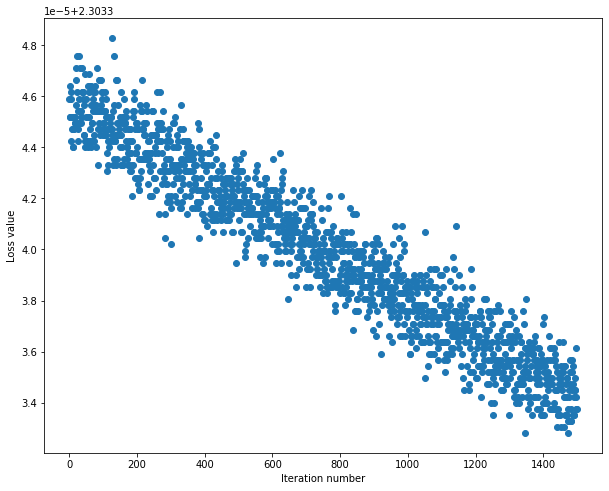

In [153]:
plt.plot(loss_hist, 'o')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [154]:
# evaluate the performance on both the training and validation set
y_train_pred = predict_linear_classifier(W, data_dict['X_train'])
train_acc = 100.0 * (data_dict['y_train'] == y_train_pred).float().mean().item()
print('training accuracy: %.2f%%' % train_acc)
y_val_pred = predict_linear_classifier(W, data_dict['X_val'])
val_acc = 100.0 * (data_dict['y_val'] == y_val_pred).float().mean().item()
print('validation accuracy: %.2f%%' % val_acc)

training accuracy: 8.43%
validation accuracy: 8.00%


In [155]:
class Softmax(LinearClassifier):
  """ A subclass that uses the Softmax + Cross-entropy loss function """
  def loss(self, W, X_batch, y_batch, reg):
    return softmax_loss_vectorized(W, X_batch, y_batch, reg)

In [166]:
results = {}
best_val = -1
best_softmax = None

learning_rates = [] # learning rate candidates
regularization_strengths = [] # regularization strengths candidates

# As before, store your cross-validation results in this dictionary.
# The keys should be tuples of (learning_rate, regularization_strength) and
# the values should be tuples (train_accuracy, val_accuracy)
results = {}

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be similar to the cross-validation that you used for the SVM,    #
# but you may need to select different hyperparameters to achieve good         #
# performance with the softmax classifier. Save your best trained softmax      #
# classifer in best_softmax.                                                   # 
################################################################################
# Replace "pass" statement with your code
X_train = data_dict['X_train']
y_train = data_dict['y_train']
X_val = data_dict['X_val']
y_val = data_dict['y_val']
learning_rate = [1e-1, 3e-3, 5e-3, 7e-3, 9e-3, 1e-2, 2e-2, 3e-2]
regularization_strengths = [1e-3, 1e-1, 3e-1, 5e-1, 7e-1, 9e-1, 1e0, 2e0, 3e0]
for l in learning_rate:
    for r in regularization_strengths:
        model = Softmax()
        train_loss = model.train(X_train, y_train, learning_rate=l, reg=r, num_iters=2000, verbose=False)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        train_acc = torch.mean((y_train_pred == y_train).float())
        val_acc = torch.mean((y_val_pred == y_val).float())

        results[l, r] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_softmax = model
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 3.000000e-03 reg 1.000000e-03 train accuracy: 0.375245 val accuracy: 0.390000
lr 3.000000e-03 reg 1.000000e-01 train accuracy: 0.361367 val accuracy: 0.374000
lr 3.000000e-03 reg 3.000000e-01 train accuracy: 0.330796 val accuracy: 0.341000
lr 3.000000e-03 reg 5.000000e-01 train accuracy: 0.318367 val accuracy: 0.329000
lr 3.000000e-03 reg 7.000000e-01 train accuracy: 0.305245 val accuracy: 0.314000
lr 3.000000e-03 reg 9.000000e-01 train accuracy: 0.303735 val accuracy: 0.318000
lr 3.000000e-03 reg 1.000000e+00 train accuracy: 0.294959 val accuracy: 0.301000
lr 3.000000e-03 reg 2.000000e+00 train accuracy: 0.270918 val accuracy: 0.284000
lr 3.000000e-03 reg 3.000000e+00 train accuracy: 0.268306 val accuracy: 0.276000
lr 5.000000e-03 reg 1.000000e-03 train accuracy: 0.387592 val accuracy: 0.394000
lr 5.000000e-03 reg 1.000000e-01 train accuracy: 0.364163 val accuracy: 0.374000
lr 5.000000e-03 reg 3.000000e-01 train accuracy: 0.335143 val accuracy: 0.349000
lr 5.000000e-03 reg 5.000000

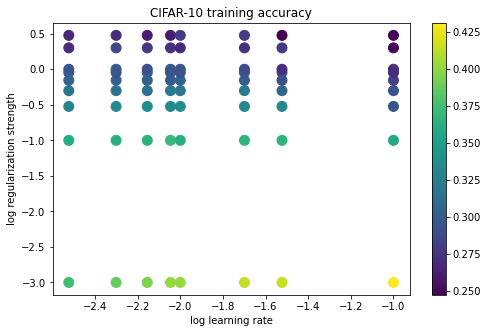

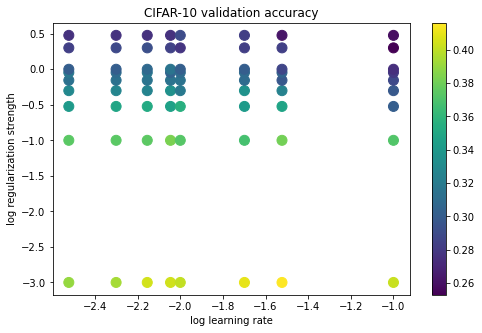

In [167]:
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

In [168]:
y_test_pred = best_softmax.predict(data_dict['X_test'])
test_accuracy = torch.mean((data_dict['y_test'] == y_test_pred).float())
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.407300


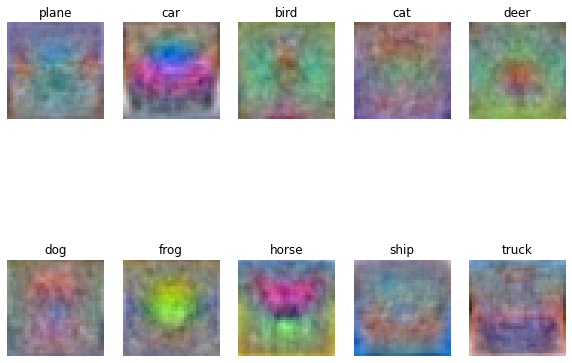

In [169]:
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(3, 32, 32, 10)
w = w.transpose(0, 2).transpose(1, 0)

w_min, w_max = torch.min(w), torch.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)

  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.type(torch.uint8).cpu())
  plt.axis('off')
  plt.title(classes[i])